# backpropcount example

In [1]:
import sys
sys.path.insert(0,'..')

from backpropcount import counting
from backpropcount import profile

import h5py
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt

from matplotlib.colors import LogNorm

In [2]:
# Function to convert linear indices to 2D (row, col) indices
def linear_to_2d_indices(linear_indices, cols):
    rows = linear_indices // cols
    cols = linear_indices % cols
    return rows, cols
    
# Function to create a 2D image from the counted frame data
def create_counted_image(frame_data, frame_height, frame_width, weight_data = None):
    # Initialize a 2D array with zeros
    image = np.zeros((frame_height, frame_width), dtype=np.int32)

    # Convert linear indices to 2D indices
    rows, cols = linear_to_2d_indices(frame_data, frame_width)

    # Set the hit pixels
    if(not(weight_data) is None):
        for r,c,w in zip(rows,cols,weight_data):
            image[r, c] = w
    else:
        image[rows,cols] = 1

    return image
    
def plot_raw_vs_counted(raw_file, counted_file, frame_index=0, x_range=None, y_range=None, weights=False):
    """
    Load and plot a specific raw frame and counted frame with optional zoom.
    
    Args:
    - raw_file (str): The path to the raw HDF5 file containing the raw frames.
    - counted_file (str): The path to the HDF5 file containing the counted results.
    - frame_index (int): The index of the frame to plot.
    - x_range (tuple of ints): The range in the x-axis to zoom in on (start, end). Default is the full range.
    - y_range (tuple of ints): The range in the y-axis to zoom in on (start, end). Default is the full range.
    - weights (bool): Whether to use weights from the counted data (default: False).
    
    Returns:
    - None: Displays the plots.
    """
    # Load the raw frame and Monte Carlo truth for the selected frame
    with h5py.File(raw_file, 'r') as h5file:
        raw_frame = h5file['/frames'][frame_index]
    
    # Load the counted data for the selected frame
    with h5py.File(counted_file, 'r') as h5file:
        frame_data = np.array(h5file['electron_events']['frames'][frame_index])
        weight_data = None
        if weights:
            weight_data = np.array(h5file['electron_events']['weights'][frame_index])
        
        # Convert the counted data into a 2D image
        frame_width = raw_frame.shape[0]
        frame_height = raw_frame.shape[1]
        counted_image = create_counted_image(frame_data, frame_height, frame_width, weight_data)
    
    # Determine the zoom range (default is full range)
    if x_range is None:
        x_range = (0, frame_width)
    if y_range is None:
        y_range = (0, frame_height)
    
    # Apply zoom
    counted_image_zoomed = counted_image[y_range[0]:y_range[1], x_range[0]:x_range[1]]
    raw_frame_zoomed = raw_frame[y_range[0]:y_range[1], x_range[0]:x_range[1]]
    
    # Plot the raw frame, counted data, and Monte Carlo truth
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    # Plot the zoomed raw frame
    im0 = axs[0].imshow(raw_frame_zoomed, cmap='viridis', extent=(x_range[0], x_range[1], y_range[1], y_range[0]))
    axs[0].set_title(f'Raw Frame {frame_index}')
    axs[0].axis('off')
    fig.colorbar(im0, ax=axs[0], orientation='vertical')
    
    # Plot the zoomed counted data
    im1 = axs[1].imshow(counted_image_zoomed, cmap='viridis', extent=(x_range[0], x_range[1], y_range[1], y_range[0]))
    axs[1].set_title(f'Counted Frame {frame_index} ({np.sum(counted_image)} counts)')
    axs[1].axis('off')
    fig.colorbar(im1, ax=axs[1], orientation='vertical')
    
    plt.show()

In [3]:
# Key files
raw_file = "../sim/frames_occupancy_10.h5"
counted_file = "counted_frames_example.h5"

th_single_elec = 10
baseline = 20.0

In [4]:
fn = h5py.File(raw_file,'r')
frames = fn['frames']
frames

<HDF5 dataset "frames": shape (1000, 51, 51), type "<u2">

#### Determine the single-electron "Gaussian" profile

Processing scan at ../sim/sparse_frames.h5...


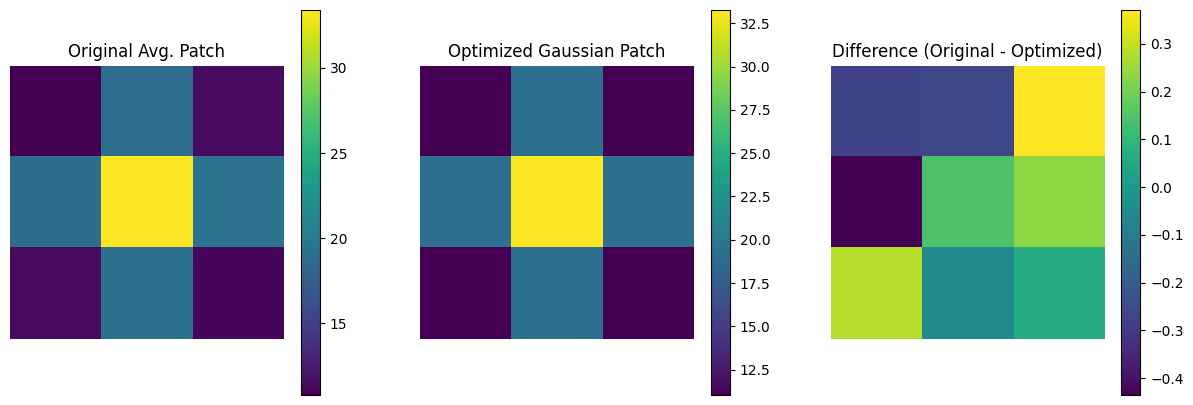

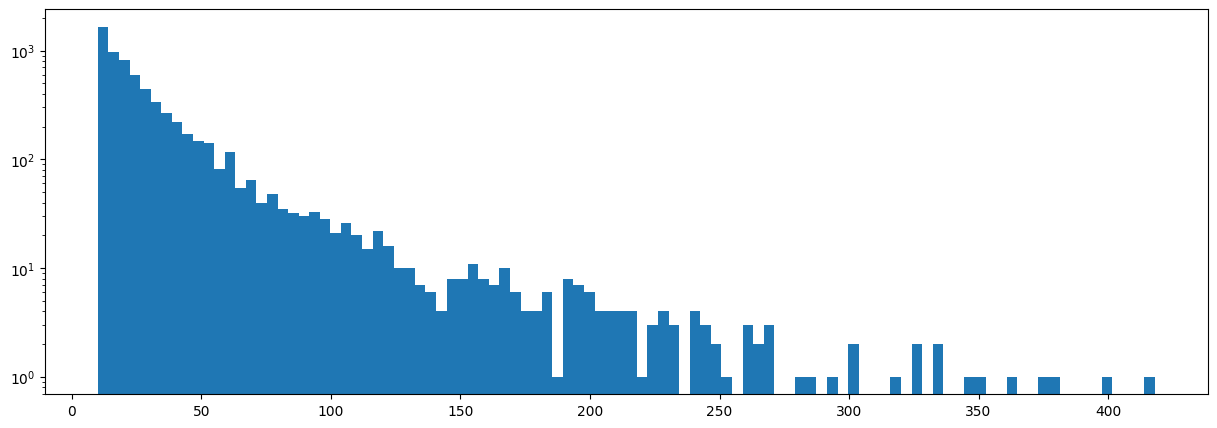

Determined average gaussian amplitude A = 33.26073561709784, sigma = 0.9524853662224863


In [5]:
nframes_profile = 1000
profile_file = "../sim/sparse_frames.h5"
avg_patch, optimized_patch, A_opt, sigma_opt = profile.gaussian_profile(profile_file, nframes_profile, baseline, th_single_elec, plot_results=True)
print(f"Determined average gaussian amplitude A = {A_opt}, sigma = {sigma_opt}")

#### Perform the counting
Note that the Gaussian amplitude and sigma determined by `profile.gaussian_profile` may not be optimal. In particular a sigma greater than 0.6 is often too large.

In [6]:
frame_width = 576
gauss_A = 40
gauss_sigma = 0.5

In [7]:
# Count the dataset (one may want to first count 1 batch to evaluate the loss)
nframes_prior = 1000
frames_per_batch = 1000
losses = counting.count_frames(raw_file, counted_file, frames_per_batch, 
                               th_single_elec, baseline, gauss_A, gauss_sigma, 
                               loss_per_frame_stop=0.5, n_steps_max=3000,
                               min_loss_patience = 100, min_loss_improvement = 0.01,
                               batch_start=0, nframes_prior=nframes_prior)

Computing the prior...
Prior values, 1000 frames, shape: (1000, 51, 51)
Summed frame dimensions: (51, 51)
Counting all 1000 frames for scan of shape [1000    1]
Analyzing in 1 batches...


 ** BATCH 0 **
-- Processing frames...
-- Counting frames...


/Users/jrenner/local/jerenner/backpropcount/notebooks/../backpropcount/counting.py:53: RuntimeWarning: invalid value encountered in divide
  conditional_prob = np.where(p_at_least_1 > 0, p_at_least_2 / p_at_least_1, 0)
/Users/jrenner/local/miniforge3/envs/py11/lib/python3.11/site-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3638.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Step 100, Loss: 30770058.0
Step 200, Loss: 15838942.0
Step 300, Loss: 9192254.0
Step 400, Loss: 5632905.0
Step 500, Loss: 3548661.0
Step 600, Loss: 2267215.5
Step 700, Loss: 1456489.75
Step 800, Loss: 935031.625
Step 900, Loss: 597076.0
Step 1000, Loss: 377917.8125
Step 1100, Loss: 236465.84375
Step 1200, Loss: 145950.515625
Step 1300, Loss: 88701.0390625
Step 1400, Loss: 53007.41015625
Step 1500, Loss: 31150.53125
Step 1600, Loss: 18121.1875
Step 1700, Loss: 10482.86328125
Step 1800, Loss: 6053.95703125
Step 1900, Loss: 3559.5634765625
Step 2000, Loss: 2151.423583984375
Step 2100, Loss: 1438.740966796875
Step 2200, Loss: 1108.2054443359375
Step 2300, Loss: 925.6766357421875
Step 2400, Loss: 785.8902587890625
* Stopping at step 2486 due to small relative improvement (0.0091)
Counted in n_steps = 2487 with loss = 780.823486328125
2359 of 2601000 (0.0907%) forced to single-electron counts
-- Saving frames...
Frame indices len = 1000 and weights = 1000


Text(0, 0.5, 'Loss')

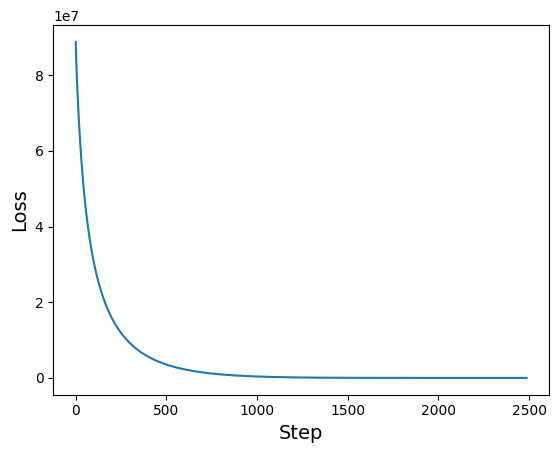

In [8]:
# Plot a loss curve
plt.plot(losses[0][0])
plt.xlabel('Step',fontsize=14)
plt.ylabel('Loss',fontsize=14)

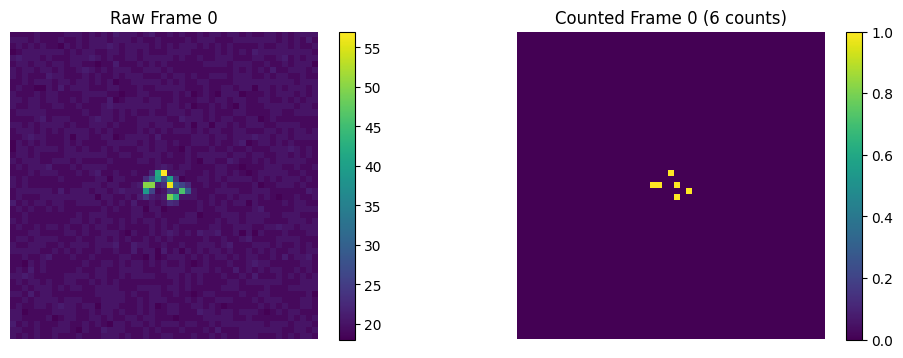

In [9]:
# Plot a raw vs. counted frame
plot_raw_vs_counted(raw_file, counted_file, frame_index=0, x_range=None, y_range=None, weights=True)